In [1]:
import pandas as pd
import numpy
import lifelines as lf

In [3]:
df = pd.read_csv("seagate_5mod_2022.csv")

In [4]:
#df_filtered = df[df.model.isin(["ST14000NM001G","ST12000NM001G"])]
df_filtered = df[~df.model.isin(['HGST HMS5C4040BLE640'])]

In [9]:
df_grouped = df_filtered.groupby("serial_number").agg(
    {"date" : ["min", "max"], 
     "model": "first",
     "capacity_bytes": "last", 
     "failure": "last", 
     'smart_194_raw': 'median'})

In [10]:
#cambiamos nombre de columnas 
df_grouped.columns = [i[0]+ "_" +i[1] for i in df_grouped.columns]
#creamos cuartiles de temperatura para hipotesis
quart_temp = pd.qcut(q = 4, x = df_grouped.smart_194_raw_median).astype(str)
#asigamos los cuantiles
df_grouped['quartiles_temperature'] = quart_temp
#creamos variable de capacidad
df_grouped['capacity_bytes_last'] = df_grouped.capacity_bytes_last.apply(lambda x: round(x/(1024**4)))
#cambiamos tipo de dato en fechas y creamos variable de dias
df_grouped.date_min = pd.to_datetime(df_grouped.date_min)
df_grouped.date_max = pd.to_datetime(df_grouped.date_max)
df_grouped["dias"] = (df_grouped.date_max - df_grouped.date_min).dt.days  
#desplegamos la información
df_grouped.head()

,date_min,date_max,model_first,capacity_bytes_last,failure_last,smart_8_raw_median,smart_10_raw_median,smart_194_raw_median,quartiles_temperature,dias
serial_number,,,,,,,,,,
ZA100GA0,2022-01-01,2022-12-31,ST8000DM002,7,0,NaN,0.0,36.0,"(31.0, 36.0]",364
ZA100HM9,2022-01-01,2022-12-31,ST8000DM002,7,0,NaN,0.0,22.0,"(17.999, 28.0]",364
ZA100HN7,2022-01-01,2022-12-31,ST8000DM002,7,0,NaN,0.0,26.0,"(17.999, 28.0]",364
ZA100HNW,2022-01-01,2022-12-31,ST8000DM002,7,0,NaN,0.0,23.0,"(17.999, 28.0]",364
ZA100HQG,2022-01-01,2022-12-31,ST8000DM002,7,0,NaN,0.0,32.0,"(31.0, 36.0]",364


 ## Análisis Descriptivo

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='smart_194_raw_median', ylabel='Count'>

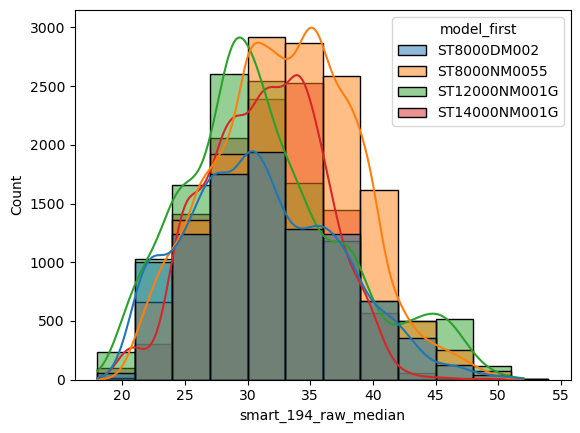

In [13]:
sns.histplot(data=df_grouped, x="smart_194_raw_median",hue = "model_first",  binwidth=3,  kde=True)

<Axes: xlabel='model_first', ylabel='smart_194_raw_median'>

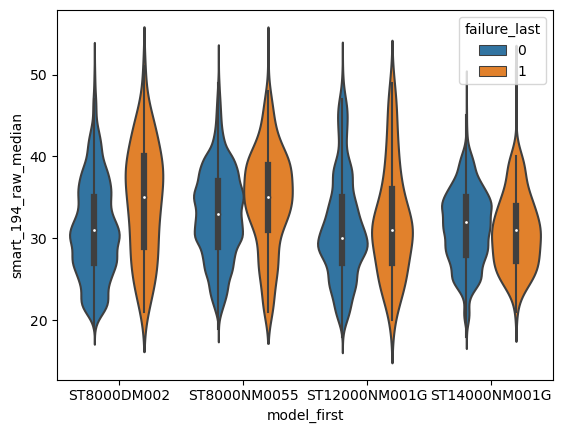

In [23]:
sns.violinplot(data=df_grouped, x = "model_first", y="smart_194_raw_median" ,hue = "failure_last",  binwidth=3,  kde=True)

In [24]:
df_grouped.groupby("model_first").failure_last.value_counts().unstack(-1)
df_grouped.groupby("model_first").failure_last.value_counts(normalize = True).unstack(-1)

failure_last,0,1
model_first,,
ST12000NM001G,0.990975,0.009025
ST14000NM001G,0.988785,0.011215
ST8000DM002,0.980753,0.019247
ST8000NM0055,0.976642,0.023358


In [25]:
!pip install kaplanmeier

In [55]:
df_kplan = df_grouped[["dias", "failure_last", "model_first", "capacity_bytes_last", "quartiles_temperature"]]

In [27]:
import kaplanmeier as km

In [28]:
df = km.example_data()

In [29]:
time_event = df_kplan['dias']
censoring = df_kplan['failure_last']
y = df_kplan['model_first']

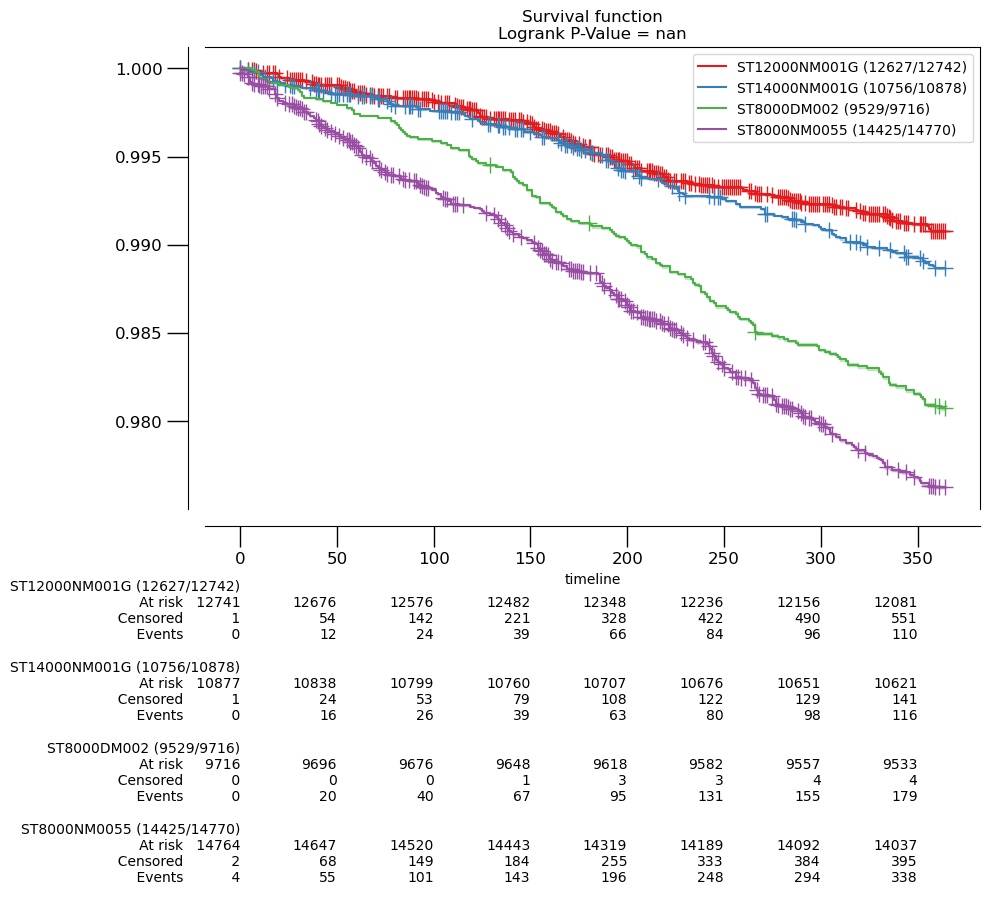

In [30]:
time_event = df_kplan['dias']
censoring = df_kplan['failure_last']
y = df_kplan['model_first']
results = km.fit(time_event, censoring, y)

# Plot
km.plot(results)

In [35]:
import pingouin as pg

anova = pg.anova(data =df_grouped, dv ="smart_194_raw_median", between =  "model_first"  )
anova
# Si existe una diferencia de temperatura en almenos un dispositivo


#Esta diferencia afecta?

,Source,ddof1,ddof2,F,p-unc,np2
0,model_first,3,48102,301.996427,2.975993e-194,0.018487


In [41]:
pg.pairwise_tukey(data =df_grouped, dv ="smart_194_raw_median", between =  "model_first" ).round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,ST12000NM001G,ST14000NM001G,31.362,31.357,0.005,0.075,0.068,1.000,0.001
1,ST12000NM001G,ST8000DM002,31.362,31.178,0.184,0.077,2.385,0.080,0.029
2,ST12000NM001G,ST8000NM0055,31.362,33.002,-1.640,0.069,-23.715,0.000,-0.274
3,ST14000NM001G,ST8000DM002,31.357,31.178,0.179,0.080,2.238,0.113,0.034
4,ST14000NM001G,ST8000NM0055,31.357,33.002,-1.645,0.072,-22.764,0.000,-0.318
5,ST8000DM002,ST8000NM0055,31.178,33.002,-1.824,0.075,-24.409,0.000,-0.318


In [40]:
pg.pairwise_gameshowell(data =df_grouped, dv ="smart_194_raw_median", between =  "model_first" ).round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,ST12000NM001G,ST14000NM001G,31.362,31.357,0.005,0.072,0.070,22932.876,1.000,0.001
1,ST12000NM001G,ST8000DM002,31.362,31.178,0.184,0.084,2.192,21586.268,0.125,0.029
2,ST12000NM001G,ST8000NM0055,31.362,33.002,-1.640,0.073,-22.378,25260.676,0.000,-0.274
3,ST14000NM001G,ST8000DM002,31.357,31.178,0.179,0.076,2.366,18143.186,0.084,0.034
4,ST14000NM001G,ST8000NM0055,31.357,33.002,-1.645,0.064,-25.846,25256.333,0.000,-0.318
5,ST8000DM002,ST8000NM0055,31.178,33.002,-1.824,0.076,-23.903,19569.144,0.000,-0.318


In [42]:
import statsmodels.stats.multicomp as multi

mc = multi.MultiComparison(df_grouped.smart_194_raw_median, df_grouped.model_first)

result = mc.tukeyhsd()

print(result)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
ST12000NM001G ST14000NM001G   -0.005 0.9999 -0.1969 0.1868  False
ST12000NM001G   ST8000DM002  -0.1837   0.08 -0.3817 0.0142  False
ST12000NM001G  ST8000NM0055   1.6403    0.0  1.4626  1.818   True
ST14000NM001G   ST8000DM002  -0.1787 0.1132 -0.3838 0.0265  False
ST14000NM001G  ST8000NM0055   1.6453    0.0  1.4596  1.831   True
  ST8000DM002  ST8000NM0055    1.824    0.0   1.632  2.016   True
-----------------------------------------------------------------


In [43]:
pg.chi2_independence(data =df_grouped, x ="failure_last", y =  "model_first" )

(model_first   ST12000NM001G  ST14000NM001G  ST8000DM002  ST8000NM0055
 failure_last                                                         
 0              12538.312352   10704.109383  9560.684572  14533.893693
 1                203.687648     173.890617   155.315428    236.106307,
 model_first   ST12000NM001G  ST14000NM001G  ST8000DM002  ST8000NM0055
 failure_last                                                         
 0                     12627          10756         9529         14425
 1                       115            122          187           345,
                  test    lambda        chi2  dof          pval    cramer  \
 0             pearson  1.000000  112.586040  3.0  3.046083e-24  0.048377   
 1        cressie-read  0.666667  112.988514  3.0  2.495210e-24  0.048464   
 2      log-likelihood  0.000000  114.968594  3.0  9.350741e-25  0.048887   
 3       freeman-tukey -0.500000  117.552929  3.0  2.596636e-25  0.049433   
 4  mod-log-likelihood -1.000000  121.173019 

In [49]:
pd.crosstab(df_grouped.failure_last, df_grouped.model_first)

model_first,ST12000NM001G,ST14000NM001G,ST8000DM002,ST8000NM0055
failure_last,,,,
0,12627,10756,9529,14425
1,115,122,187,345


In [48]:
from scipy.stats import chi2_contingency

data  = pd.crosstab(df_grouped.failure_last, df_grouped.model_first).values 

chi2, p, dof, expected = chi2_contingency(data) 

print("El valor chi cuadrado es:", chi2)
print("El valor p es:", p)
print("Los grados de libertad son:", dof)
print("La tabla de contingencia esperada es:")
print(expected)
# la probabilidad de la falla es dependiente al modelo 

El valor chi cuadrado es: 112.58603989973219
El valor p es: 3.0460829061306125e-24
Los grados de libertad son: 3
La tabla de contingencia esperada es:
[[12538.31235189 10704.10938344  9560.68457157 14533.89369309]
 [  203.68764811   173.89061656   155.31542843   236.10630691]]


In [50]:
pd.crosstab(df_grouped.failure_last, df_grouped.quartiles_temperature)

quartiles_temperature,"(17.999, 28.0]","(28.0, 31.0]","(31.0, 36.0]","(36.0, 52.0]"
failure_last,,,,
0,14128,9705,13650,9854
1,184,104,218,263


In [52]:
from scipy.stats import chi2_contingency

data  = pd.crosstab(df_grouped.failure_last, df_grouped.quartiles_temperature).values 

chi2, p, dof, expected = chi2_contingency(data) 

print("El valor chi cuadrado es:", chi2)
print("El valor p es:", p)
print("Los grados de libertad son:", dof)
print("La tabla de contingencia esperada es:")
print(expected)
# la probabilidad de la falla es dependiente al rango de temperatura

El valor chi cuadrado es: 91.49045112100673
El valor p es: 1.0480941860489893e-19
Los grados de libertad son: 3
La tabla de contingencia esperada es:
[[14083.21506673  9652.1979171  13646.31264291  9955.27437326]
 [  228.78493327   156.8020829    221.68735709   161.72562674]]


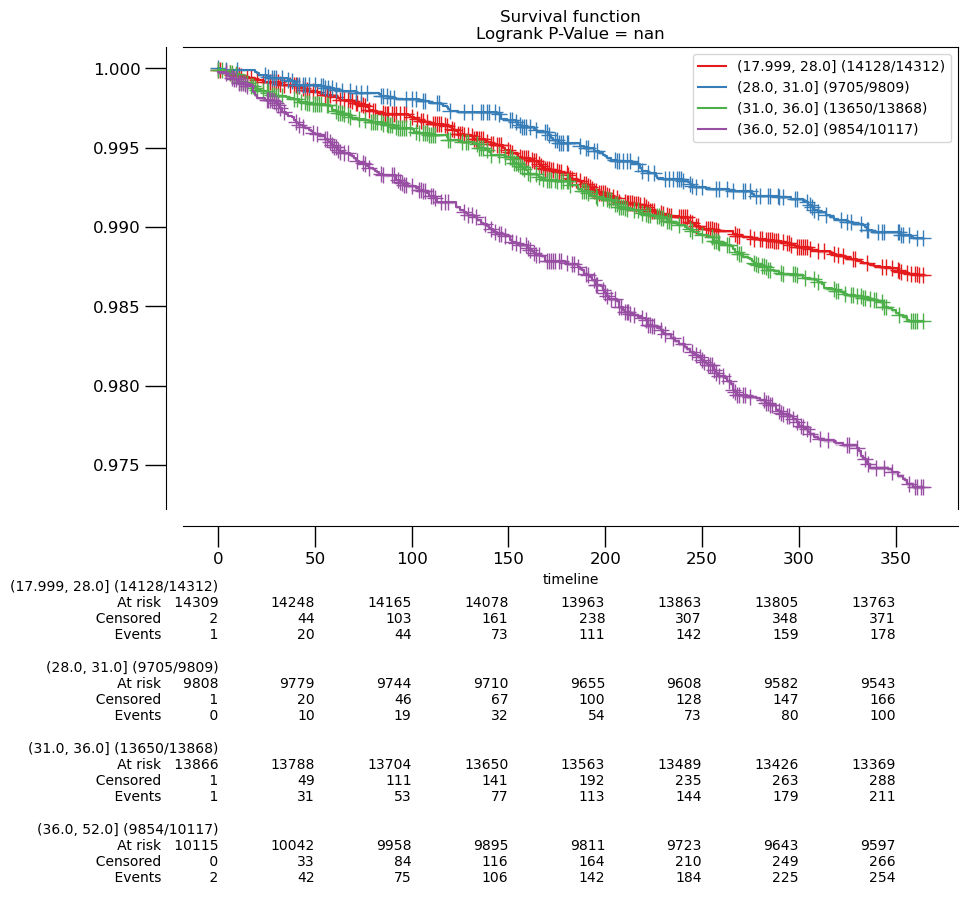

In [56]:
time_event = df_kplan['dias']
censoring = df_kplan['failure_last']
y = df_kplan['quartiles_temperature']
results = km.fit(time_event, censoring, y)

# Plot
km.plot(results)